#Math 156: Assignment 3 on NLP and RNNs

Due midnight on **March 7th (Tuesday)**, which gives you 8 days.
This is an individual assignment, however you are encouraged to ask questions via BruinLearn only (I have created a post for this assignment under Discussions). Healthy discussions and questions will be allowed, sharing of direct answers or code will not. Please make a copy of the assignment (into your own google drive), you will not be able to edit the original. The assignment contains many desriptions and links...when in doubt, read them. When in more doubt, google. This assignment has the standard late submission policy.

In this notebook, we will consider a text classification task and try solving it with several basic NLP models: 
* bag-of-words + linear model
* word2vec + linear model
* recurrent neural networks
* long short-term memories

Particularly, we will be building a classifier which predicts whether a movie review is positive or negative. 


# Part 0: Download data

A library called `dataget` is used to download data, as it provides a convenient interface for the dataset we want to use, [IMDB](https://ai.stanford.edu/~amaas/data/sentiment/). If you wish to work with your custom dataset, you can upload it to Google Colab directly, download it with `!wget <link_to_dataset>` or to search for libraries which can download it for you.

In [ ]:
!pip install dataget
# Google Colab has only some of python libraries preinstalled
# others can be downloaded with pip, ! means using a command line tool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 KB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 KB 7.2 MB/s eta 0:00:00
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7919 sha256=54be0a5677778c5a246a9b6b2b673c3fe123e1eeed3b3c177bd04befd0102d84
  Stored in directory: /root/.cache/pip/wheels/27/40/a8/6447ee4a00cb87e2084e1ef1df5c38433720cc1090be082842
Successfully built idx2numpy
  Attempting uninstall: chardet
    Found existing installation: chardet 4.0.0
    Uninstalling chardet-4.0.0:
      Successfully uninstalled chardet-4.0.0


In [ ]:
import dataget

df_train, df_test = dataget.text.imdb_reviews().get()

df_train.reset_index(drop=True, inplace=True)

Extracting aclImdb_v1.tar.gz: 100%|██████████| 100019/100019 [00:18<00:00, 5282.40it/s]


In [ ]:
df_train.head()
# we will need a "text" field and a "label" field

,text_path,text,label
0,data/text_imdb_reviews/aclImdb/train/pos/8754_...,I watched this movie 11 years ago in company w...,1
1,data/text_imdb_reviews/aclImdb/train/pos/1930_...,"This film is hilarious, original, & beautifull...",1
2,data/text_imdb_reviews/aclImdb/train/pos/132_9...,Storyline: Max von Sydow's voice-over narratio...,1
3,data/text_imdb_reviews/aclImdb/train/pos/6164_...,Are we really making 'video nasties' again? In...,1
4,data/text_imdb_reviews/aclImdb/train/pos/4870_...,The movie celebrates life.<br /><br />The worl...,1


In [ ]:
# are positive and negative classes balanced? -> yes
df_test["label"].value_counts()

1    12500
0    12500
Name: label, dtype: int64

# Part 1: Preprocessing and Bag-of-words + Linear classificaion

In [ ]:
# load libraries commonly used in machine learning
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Examples of texts:

In [ ]:
df_train["text"][[345, 134, 112, 10000]].values

array(['TOM HULCE* turns in yet another Oscar-worthy performance as Dominick Luciano, the brain-damaged garbage man who\'s helping put his brother (Ray Liotta as Eugene) through medical school.<br /><br />This is a must-see for all movie lovers and all lovers of life and people!<br /><br />===========> *From the small studder to the eratic dancing, to the repeated words "Oh, Jeez" whenever Nicky is in a bind, the belieavablitly of Tom\'s performance is so excellent that you will have to concentrate to remember that it\'s an actor on screen!',
       'This film deals with the atrocity in Derry 30 years ago which is commonly known as Bloody Sunday.<br /><br />The film is well researched, acted and directed. It is as close to the truth as we will get until the outcome of the Saville enquiry. The film puts the atrocity into context of the time. It also shows the savagery of the soldiers on the day of the atrocity. The disgraceful white-wash that was the Widgery Tribunal is also dealt with.

Preprocessing: let's remove tags, punctuation and apply lowercasing. [3 points]

__Tools:__ for preprocessing, module `re` is commonly used. Actually, whatever you need to do with textual data, the easiest way is to google each step and copy commands from the first (usually StackOverflow) link :)

In [ ]:
import re, string

def process_string(text):
    temp = ''.join(char for char in text if char not in '<>')
    temp = temp.translate(str.maketrans('', '', string.punctuation)).lower()
    text = ' '.join(temp.split())
    return text

# demo
print("Example of a preprocessed text:")
print(process_string(df_train["text"][112]))

Example of a preprocessed text:
br br i take issue with the other reviewers comments for the simple reason that this is a mystery film not a supernatural one it is not the only film to have a seemingly supernatural explanation vampires but turns out to be a very mundance onebr br other films that come to mind are edgar wallaces before dawn and the more famous mark of the vampire br br the film does a wonderful job in creating a very spooky atmosphere similar dracula when renfield meets the count on the staircase of his castle or in mark of the vampire when the two people look thru the windows of the castle ruins and see a corpse playing an organ while luna descends using wings very surrealbr br if one likes these often silent atmospheric touches this film is a mustbr br norm vogel


In [ ]:
# after having a working process_string, apply your function to train and test datasets
df_train["text"] = df_train["text"].apply(process_string)
df_test["text"] = df_test["text"].apply(process_string)

Let's build a simplest model: bag-of-words [10 points] + linear classification [10 points]

__Tools__: for this task, `sklearn` is the most common choice. We have discussed both these concepts in class, but a more detailed tutorial on text classification with bag of words and linear models in `sklearn` can be found [here](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html).

In [ ]:
# 1. bag-of-words extractor (5 points)
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(min_df=5)
X_train, X_test = df_train["text"], df_test["text"]

X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)

print("Train shape:", X_train_counts.shape, "Test shape:", X_test_counts.shape)

Train shape: (25000, 30099) Test shape: (25000, 30099)


In [ ]:
# 2. logistic regression (5 points)
y_train = df_train["label"]
y_test = df_test["label"]

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(max_iter = 5000)
model.fit(X_train_counts, y_train)
y_pred = model.predict(X_test_counts)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.86912


Some explanations:
* We talked about bag of words as an early pass (before word-2-vec). Recall that each sentence is a vector of size = # of words in the text corpus. And values are integer values denoting count of each word in that sentence.
* We talked about logistic regression early in the course (linear regression+sigmoid). This is NOT a deep neural network model. So your model does not have layer after layer. When in doubt, google how to initialize a model.
* In bag of words, we decided to specify `min_df=5` (only keep words which occured in at least 5 documents): the linear model's weight for rare words will be updated very rarely and will not go far from the initial random initialization. You can play around with this, and see what it does to very rare words.
* `X_train_counts` and `X_test_counts` are matrices which contain a lot of 0's and only a small amount of other integers
* There quite a lot of hyperparameters in `CountVectorizer` and `LogisticRegression`, tuning which can potentially increase performance (see an optional Exercise 1 below).
* We use a simplest metric, accuracy, as it is very easy to interpret (this is a portion of examples for which we made correct predictions). As we have balanced classes and binary classiication, we say that everything below 50% accuracy is a bad model, because 50% is an accuracy of a constant or random prediction.

You can probably increase the accuracy by tuning hyperparameters, and we will compare it to other models in the next section. You're welcome to tune in Exercise 1 for your own understanding, otherwise around >80% accuracy should be sufficient to proceed. Below we will also take a look at the resulting model weights.

Words in the vocabulary:

In [ ]:
words = count_vect.get_feature_names_out()
words[500:530]

array(['abusing', 'abusive', 'abut', 'abysmal', 'abysmally', 'abyss',
       'academic', 'academy', 'accelerated', 'accent', 'accentbr',
       'accented', 'accents', 'accentsbr', 'accentuate', 'accentuated',
       'accentuates', 'accept', 'acceptable', 'acceptance', 'accepted',
       'accepting', 'accepts', 'access', 'accessibility', 'accessible',
       'accident', 'accidental', 'accidentally', 'accidentbr'],
      dtype=object)

Let's look at words with highest and lowest weights:

In [ ]:
# save weights from the model and words into a dataframe
weights = pd.DataFrame({"coef": model.coef_[0],
                        "word": words})
weights = weights.sort_values(by="coef")
print('Words with lowest weights (they "vote" for the negative label)')
print(weights[:20])
print('Words with higest weights (they "vote" for the positive label)')
print(weights[-20:])

Words with lowest weights (they "vote" for the negative label)
           coef            word
285   -2.762004             410
29098 -2.210889           waste
29756 -2.173520           worst
7648  -2.140661  disappointment
20317 -1.911966          poorly
259   -1.835265             310
15144 -1.806977           lacks
2171  -1.693050           awful
224   -1.673604             210
15303 -1.527366       laughable
16979 -1.507645            mess
3647  -1.454496         britney
19895 -1.440840           photo
10644 -1.431146     forgettable
28146 -1.410952         unfunny
17687 -1.394126           mst3k
12996 -1.377174        horrible
3355  -1.359697          boring
9748  -1.343178           fails
7645  -1.341931   disappointing
Words with higest weights (they "vote" for the positive label)
           coef         word
12705  1.170470       highly
7097   1.179655   delightful
12943  1.182729       hooked
26055  1.204567       superb
19707  1.230808      perfect
10418  1.236345       flight

The presence of words with highest weights (positive) "votes" for the positive class in the linear model, and the presence of words with lowest weights (negative) "votes" for the negative class.

__\*\*\*Exercise 1\*\*\*__

(it's completely optional and suggested for students who want to try models themselves, it's not rated and does not affect final marks.)

Machine learning models, inlcuding linear models, are very sensitive to hyperparameters and data preprocessing. One should try different options, measuring performance on the development data or using [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html), to get the best performing model. It is important to avoid using test data in hyperparameters tuning (hyperparameters are tuned during training using training data) and only use it to test the transferability of chosen configurations to _unseen_ data. Here is what we suggest you to do:

* Split `X_train["text"]` and `X_train["label"]` into "training" and development set (you can use [sklearn's train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with `test_size=0.2`)
* For each of the following hyperparameters, train on the new "training" set and evaluate accuracy on the newly created development set. Choose hyperparameter configuration with highest accuracy. Then retrain the model on the full initial training set with the chosen hyperparameter configuration and compare accuracy on the _test_ set to the initial model we trained above. __The goal__ is to have higher resulting test accuracy, but without using test data in the tuning process!
* Try tuning hyperparameter `C` (regularization strength) in [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). You can consider grid `[0.001, 0.01, ..., 10, 100]`. For this specific hyperparameter, you can also use [`LogisticRegressionCV` implementation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html), which conducts cross-validation.
* Try using [`TfIdfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) instead of `CountVectorizer`
* Try tuning hyperparameters in `CountVectorizer` or `TfIdfVectorizer`, e.g. `min_freq`, `ngram_range`, or `binary`. See [CountVectorizer's documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for the description of these hyperparameters.

# Part 2: word embeddings and linear models with them

__Tools:__ for working with word embeddings, `gensim` is a widely used library. You can either download some pretrained embeddings (as we will do) or train embeddings on your data (with an easy-to-run command). You can find an introductory tutorial [here](https://www.nltk.org/howto/gensim.html) or [here](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html), and pretrained models are listed [here](https://github.com/RaRe-Technologies/gensim-data) (mostly English, unfortunately). Fyi, another popular choise is the `fasttext` library ([python module intro](https://fasttext.cc/docs/en/python-module.html), [command line intro](https://fasttext.cc/docs/en/unsupervised-tutorial.html), [pretrained models for 157 languages](https://fasttext.cc/docs/en/crawl-vectors.html)).

The next cell loads some pretrained model. Here a small one is chosen, to avoid long downloading, but you can try a larger one, e. g. `word2vec-google-news-300`

In [ ]:
# a smaller model, faster download and no problems with out of memory
import gensim.downloader as api
wv = api.load('glove-wiki-gigaword-50')

[==================================================] 100.0% 66.0/66.0MB downloaded


In [ ]:
# number of words in the model
len(wv.vocab)

400000

In [ ]:
# example of a word embedding
wv['paris']

array([ 0.76989 ,  1.181   , -1.1299  , -0.74725 , -0.5969  , -1.0518  ,
       -0.46552 ,  0.27009 , -0.99243 , -0.04864 ,  0.28642 , -0.75261 ,
       -1.0566  , -0.19205 ,  0.572   , -0.24391 , -0.36054 , -0.70876 ,
       -0.91951 , -0.27024 ,  1.5131  ,  1.0313  , -0.55713 ,  0.52952 ,
       -0.71494 , -1.0949  , -0.60565 ,  0.31329 , -0.44488 ,  0.55915 ,
        2.1429  ,  0.43389 , -0.5529  , -0.24261 , -0.43679 , -0.96014 ,
        0.25828 ,  0.79385 ,  0.37132 ,  0.49623 ,  0.84359 , -0.25875 ,
        1.5616  , -1.1199  ,  0.091676,  0.076675, -0.45084 , -0.86104 ,
        0.97599 , -0.35615 ], dtype=float32)

In [ ]:
# example of similarity between words
print(wv.similarity("paris", "france"))
print(wv.similarity("paris", "china"))
print(wv.similarity("paris", "usa"))

0.802533
0.34973487
0.2978267


In [ ]:
# example of finding most similar words
wv.most_similar("france")

[('french', 0.8868120908737183),
 ('belgium', 0.8631512522697449),
 ('paris', 0.8025329113006592),
 ('spain', 0.7909148931503296),
 ('netherlands', 0.7893801331520081),
 ('italy', 0.7788637280464172),
 ('germany', 0.7744609117507935),
 ('european', 0.7626757025718689),
 ('switzerland', 0.757765531539917),
 ('europe', 0.7539670467376709)]

In [ ]:
wv.most_similar("tea")

[('coffee', 0.8079648017883301),
 ('drinks', 0.7730340361595154),
 ('drink', 0.7591135501861572),
 ('teas', 0.7377562522888184),
 ('fruit', 0.730494499206543),
 ('snack', 0.7249595522880554),
 ('coconut', 0.7229518890380859),
 ('sugar', 0.7206286787986755),
 ('juice', 0.7178527116775513),
 ('vegetable', 0.7024728059768677)]

In [ ]:
# a classic "king - man + woman" example
wv.most_similar(positive=['woman','king'], negative=['man'], topn = 1)

[('queen', 0.8523603677749634)]

In [ ]:
# tea - china + france
wv.most_similar(positive=['france','tea'], negative=['china'], topn = 1)

[('champagne', 0.7019561529159546)]

In [ ]:
# croissant - france + usa
wv.most_similar(positive=['usa','croissant'], negative=['france'], topn = 1)

[('cracker', 0.6282730102539062)]

To play with pretrained embeddings yourself, you only need to run the cell at the beginning of Part 2.

Let's extract pretrained vectors for all words in our data, average embeddings over sequences and train logistic regression on top of the resulting features (10 points):

In [ ]:
# write a function to turn the given sentence ''text'' into a sequence of vectors, ignoring 'out of vocabulary' words
# wv is the dictionary for all word embeddings, i.e., wv[word] will give you the embedding of that word.
# Hint: 1. to check if a word is out of vocabulary, call 'word in wv' and see if it returns True or False
#       2. to get embedding for a word, call 'wv[word]'
def text_to_vector(text, wv):
    vectors = []
    words = [w.lower() for w in text.split() if w.lower() in wv]
    vectors = np.array([wv[word] for word in words])
    return np.mean(vectors, axis=0)

# demo
print("Example of a vector computed for a text:")
print(text_to_vector(df_train["text"][112], wv))

Example of a vector computed for a text:
[ 4.03036803e-01  2.26124763e-01 -1.94381744e-01 -1.37909666e-01
  3.59673113e-01  2.44850710e-01 -2.81545281e-01 -2.33770505e-01
 -2.36470148e-01  1.56360455e-02 -2.90522445e-02  2.00502917e-01
 -3.06571603e-01  5.82588986e-02  3.45339000e-01  8.12849775e-02
  8.70722979e-02  2.58340426e-02 -4.49621081e-01 -2.72033304e-01
 -2.52034934e-03  8.25625286e-02  1.28303066e-01  7.03524128e-02
  1.77512124e-01 -1.31450295e+00 -5.28752685e-01  1.51897088e-01
  1.36917427e-01 -1.83645144e-01  2.78965902e+00 -6.75237700e-02
 -1.15567975e-01 -2.93688416e-01  6.77593648e-02  6.21846579e-02
  1.20345406e-01  2.69264472e-03 -6.01344593e-02 -1.32771403e-01
 -7.26292208e-02  1.59432456e-01 -9.87929255e-02  8.03667083e-02
 -9.42643285e-02  9.33142975e-02  1.76950414e-02 -2.22160146e-01
  8.09538411e-04 -4.72985581e-02]


In [ ]:
# convert all training/testing data into word embeddings
X_train_wv = np.zeros((df_train.shape[0], wv.vectors.shape[1]))
for i, text in enumerate(df_train["text"]):
    X_train_wv[i] = text_to_vector(text, wv)

X_test_wv = np.zeros((df_test.shape[0], wv.vectors.shape[1]))
for i, text in enumerate(df_test["text"]):
    X_test_wv[i] = text_to_vector(text, wv)

In [ ]:
y_train = df_train["label"]
y_test = df_test["label"]

# check data shapes
X_train_wv.shape, X_test_wv.shape, y_train.shape, y_test.shape

((25000, 50), (25000, 50), (25000,), (25000,))

In [ ]:
# a good practice is to scale data before training
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# as previous example, you will need to use functions fit_transform() and 
# transform() on X_train_wv and X_test_wv
X_train_wv = scaler.fit_transform(X_train_wv)
X_test_wv = scaler.transform(X_test_wv)

In [ ]:
# train LogisticRegression with glove-wiki-gigaword-50/word2vec-google-news-300 
# embeddings

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(max_iter = 5000)
model.fit(X_train_wv, y_train)
y_pred = model.predict(X_test_wv)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7532


How does the accuracy differ when using 300-dim-word2vec embeddings vs 50-dimensional-glove embeddings? Explain why you expect your answer.

The use of glove embeddings resulted in lower accuracy when compared to word2vec with the same model. The reduced accuracy of the 50-dimensional embeddings is probably due to the significant loss of important information, which could have been learned by the model, due to the lower number of dimensions. However, it was not possible to carry out a thorough comparison as the word2vec failed to load.

Exercise 2 (20 points)

You can now try training both versions of logistic regression, with bag-of-words or pretrained embeddings, for some other dataset. You can select any dataset e. g. from [Kaggle](https://www.kaggle.com/datasets?search=text+classification) or just use the one we picked for you: the [AGNews dataset](https://paperswithcode.com/dataset/ag-news). It consists of news articles constructed by assembling titles and description fields of articles from the 4 topics (“World”, “Sports”, “Business”, “Sci/Tech”), and the task is to predict one category per text. You should decide what preprocessing you want to do (5 points), train two models (5 points each), optimize via hyperparameter tuning and tuning of things like min_df, type of embedding (glove vs word2vec) etc. (5 points).

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 18.1 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
dataset = load_dataset("ag_news")
# dataset["train"]["text"], dataset["test"]["text"]
# dataset["train"]["label"], dataset["test"]["label"]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

# Model 1: Glove Encodings

The first model I will do for this example is with using the glove encodings again. I will do the same preprocesing as before, as scaling the data was mentioned to be a good preprocessing step. I will finally train my logistic regression model again.

In [ ]:
X_train = np.array([text_to_vector(text, wv) for text in dataset["train"]["text"]])
X_test = np.array([text_to_vector(text, wv) for text in dataset["test"]["text"]])

y_train = dataset["train"]["label"]
y_test = dataset["test"]["label"]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression(max_iter = 5000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8732894736842105


# Model 2: Bag of words

The second model I will do for this example is the bag-of-words one, like we did in part 1. I will use 50 as the new minimum df so when doing count vectorization. This is because I noticed that this new dataset has many more rows in it, so words should appear in more rows than before in order to be considered significant. Next, I will train the same logistic regression as before on this new dataset and look at the results.

In [ ]:
X_train = np.vectorize(process_string)(dataset["train"]["text"])
X_test = np.vectorize(process_string)(dataset["test"]["text"])

# count vectorization
count_vect = CountVectorizer(min_df=50)
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# get labels
y_train = dataset["train"]["label"]
y_test = dataset["test"]["label"]

# implementing model
model = LogisticRegression(max_iter = 5000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8975


I see that the accuracy is slightly higher for Bag of Words. This is interesting, as Bag of Words is considered an older approach.

# Part 3: Recurrent neural networks

Let's train recurrent neural networks on our data and compare it to previously considered linear models. Here we will need more code.

#### 3.1 Tokenization (2 points)

The first step is tokenizing our data, i. e. segmenting words into subwords. 

__Tools__: for this task, `sentencepiece` ([link](https://github.com/google/sentencepiece)) is a widely used choice. With this library, you usually train tokenizer on your data (see examples by following the link). You can also try using some pretrained tokenizer, which can be found in the [Huggingface library](https://huggingface.co/docs/tokenizers/index) (this library of course also allows training your custom tokenizers). We will use the popular [GPT2 pretrained tokenizer](https://huggingface.co/docs/transformers/model_doc/gpt2) which was trained on a large English corpora. Huggingface also provides multilingual tokenizers, e. g. [BLOOM tokenizer](https://huggingface.co/docs/transformers/model_doc/bloom). 


In [ ]:
!pip install transformers
# Google Colab has only some of python libraries preinstalled
# others can be downloaded with pip, ! means using a command line tool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 76.8 MB/s eta 0:00:00


In [ ]:
# tokenization example
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
print(tokenizer.tokenize(df_train["text"][112]))
# Ġ symbol denotes white space

['br', 'Ġbr', 'Ġi', 'Ġtake', 'Ġissue', 'Ġwith', 'Ġthe', 'Ġother', 'Ġreviewers', 'Ġcomments', 'Ġfor', 'Ġthe', 'Ġsimple', 'Ġreason', 'Ġthat', 'Ġthis', 'Ġis', 'Ġa', 'Ġmystery', 'Ġfilm', 'Ġnot', 'Ġa', 'Ġsupernatural', 'Ġone', 'Ġit', 'Ġis', 'Ġnot', 'Ġthe', 'Ġonly', 'Ġfilm', 'Ġto', 'Ġhave', 'Ġa', 'Ġseemingly', 'Ġsupernatural', 'Ġexplanation', 'Ġvampires', 'Ġbut', 'Ġturns', 'Ġout', 'Ġto', 'Ġbe', 'Ġa', 'Ġvery', 'Ġmund', 'ance', 'Ġone', 'br', 'Ġbr', 'Ġother', 'Ġfilms', 'Ġthat', 'Ġcome', 'Ġto', 'Ġmind', 'Ġare', 'Ġed', 'gar', 'Ġwall', 'aces', 'Ġbefore', 'Ġdawn', 'Ġand', 'Ġthe', 'Ġmore', 'Ġfamous', 'Ġmark', 'Ġof', 'Ġthe', 'Ġvampire', 'Ġbr', 'Ġbr', 'Ġthe', 'Ġfilm', 'Ġdoes', 'Ġa', 'Ġwonderful', 'Ġjob', 'Ġin', 'Ġcreating', 'Ġa', 'Ġvery', 'Ġsp', 'ooky', 'Ġatmosphere', 'Ġsimilar', 'Ġdr', 'ac', 'ula', 'Ġwhen', 'Ġren', 'field', 'Ġmeets', 'Ġthe', 'Ġcount', 'Ġon', 'Ġthe', 'Ġstaircase', 'Ġof', 'Ġhis', 'Ġcastle', 'Ġor', 'Ġin', 'Ġmark', 'Ġof', 'Ġthe', 'Ġvampire', 'Ġwhen', 'Ġthe', 'Ġtwo', 'Ġpeople', 'Ġlook', '

You can see that most words in our data are quite commonly-used and are not split into subwords.

`tokenizer.tokenize` provides a nice visualization of the tokenization process, but we actually need to convert our texts into integer sequences (each integer denotes an index in the vocabulary):

In [ ]:
print(tokenizer.encode(df_train["text"][112]))

[1671, 865, 1312, 1011, 2071, 351, 262, 584, 30702, 3651, 329, 262, 2829, 1738, 326, 428, 318, 257, 10715, 2646, 407, 257, 22239, 530, 340, 318, 407, 262, 691, 2646, 284, 423, 257, 9775, 22239, 7468, 35299, 475, 4962, 503, 284, 307, 257, 845, 27943, 590, 530, 1671, 865, 584, 7328, 326, 1282, 284, 2000, 389, 1225, 4563, 3355, 2114, 878, 17577, 290, 262, 517, 5863, 1317, 286, 262, 23952, 865, 865, 262, 2646, 857, 257, 7932, 1693, 287, 4441, 257, 845, 599, 29655, 8137, 2092, 1553, 330, 4712, 618, 8851, 3245, 11185, 262, 954, 319, 262, 27656, 286, 465, 16669, 393, 287, 1317, 286, 262, 23952, 618, 262, 734, 661, 804, 33834, 262, 9168, 286, 262, 16669, 20073, 290, 766, 257, 21304, 2712, 281, 1618, 981, 300, 9613, 1715, 2412, 1262, 12098, 845, 28201, 1671, 865, 611, 530, 7832, 777, 1690, 10574, 20938, 18105, 428, 2646, 318, 257, 1276, 1671, 865, 2593, 410, 519, 417]


In [ ]:
# sanity check
tokenizer.convert_ids_to_tokens([5661])

['this']

In [ ]:
# take a look at the vocabulary size
tokenizer.vocab_size

50257

In [ ]:
X_train_tok = [tokenizer.encode(text) for text in df_train["text"]]
X_test_tok = [tokenizer.encode(text) for text in df_test["text"]]

Token indices sequence length is longer than the specified maximum sequence length for this model (1130 > 1024). Running this sequence through the model will result in indexing errors


In [ ]:
print(X_train_tok[:3])

[[72, 7342, 428, 3807, 1367, 812, 2084, 287, 1664, 351, 616, 1266, 4048, 1545, 1312, 1392, 616, 8492, 9941, 5954, 503, 523, 1312, 42547, 1254, 845, 922, 1671, 865, 1312, 4444, 510, 24976, 340, 1263, 640, 663, 257, 1327, 2342, 611, 345, 1011, 287, 1848, 326, 340, 7529, 351, 14738, 19125, 29355, 1176, 1637, 2563, 4979, 290, 262, 3257, 1327, 3074, 326, 7529, 351, 2877, 287, 257, 3215, 7356, 1671, 865, 262, 7205, 318, 319, 663, 6994, 1241, 734, 286, 262, 1466, 326, 1312, 22279, 262, 749, 3491, 290, 29294, 257, 922, 1517, 537, 7626, 288, 7305, 318, 355, 13779, 290, 23332, 355, 1464, 981, 479, 378, 639, 5331, 1000, 318, 4457, 3024, 290, 16316, 257, 3734, 2854, 2855, 2834, 805, 318, 635, 1049, 290, 15687, 465, 1554, 81, 26523, 14482, 1671, 865, 612, 389, 867, 7110, 30953, 284, 3100, 422, 290, 787, 340, 281, 3499, 5874, 1998, 5556, 340, 2523, 262, 2408, 1661, 379, 294, 16188, 1671, 865, 428, 318, 281, 42308, 3807, 407, 867, 7328, 588, 428, 530, 423, 1282, 510, 287, 2274, 2106, 340, 815, 787, 3

## 3.2 Vanilla RNN and LSTM

__Tools:__ for training neural networks, two most popular libraries are PyTorch and TensorFlow, we will use the first one. A tutorial on training RNNs for text classification in PyTorch: [link](https://coderzcolumn.com/tutorials/artificial-intelligence/pytorch-lstm-for-text-classification-tasks).

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### 3.2.1 Clipping and padding sequences (2 points)

When we pass data to a neural network, we group sequences into mini-batches, to speed-up the training process and to improve convergence. But sequences have various lengths, while neural networks operate with matrices or tensors with fixed dimensionalities. To bring things together, we will _pad_ short sequences with some special index, e. g. 0, and clip too long sequences.  Before doing that, we need to decide on the maximum sequence length we want to work with.  Let's plot the histogram of lengths do do that:

Text(0, 0.5, 'Number of sequences')

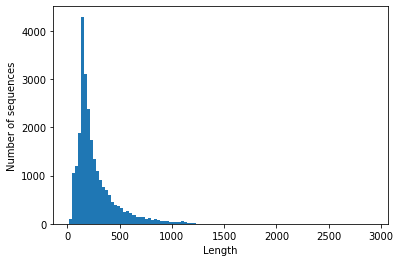

In [ ]:
_ = plt.hist([len(s) for s in X_train_tok], 100)
plt.xlabel("Length")
plt.ylabel("Number of sequences")

All tokens beyond the maximum sequence length will be clipped. Using large `max_seq_len` would accomodate all tokens, but be less time-efficient. Let's choose something in the middle, e. g. `max_seq_len=500`.

In [ ]:
max_seq_len = 500   

# clip sequences: for each element in X_train_tok and X_test_tok, truncate the length of each entry at max_seq_len. Ignore what comes after.
# therefore each element has length at most max_seq_len
# hint: list comprehension is your friend, or this can be done with a loop
X_train_tok = [seq[:500] for seq in X_train_tok]
X_test_tok = [seq[:500] for seq in X_test_tok]

# create masks
mask_train = [[1]*len(s)+[0]*(max_seq_len-len(s)) for s in X_train_tok]
mask_test = [[1]*len(s)+[0]*(max_seq_len-len(s)) for s in X_test_tok]

# pad sequences: for each element in X_train_tok and X_test_tok, pad each
# element at the end with 0s such that each element has length exactly max_seq_len
X_train_tok = [seq + [0] * (500 - len(seq)) if len(seq) <= 501 else seq for seq in X_train_tok]
X_test_tok = [seq + [0] * (500 - len(seq)) if len(seq) <= 501 else seq for seq in X_test_tok]

In [ ]:
print(X_train_tok[3])
# indices at the beginning and 0's at the end
print(mask_train[:3])
# 1's at the beginning and 0's at the end

[533, 356, 1107, 1642, 2008, 299, 459, 444, 757, 287, 262, 34731, 286, 257, 4875, 3094, 3159, 1263, 4466, 28763, 286, 807, 3020, 428, 318, 2407, 257, 6594, 12716, 612, 318, 257, 1643, 1165, 881, 1621, 290, 379, 1661, 428, 4329, 588, 257, 3067, 5119, 355, 674, 41487, 15455, 262, 3133, 6201, 10222, 286, 1582, 271, 41478, 3686, 290, 716, 22506, 1312, 716, 2158, 852, 2138, 442, 333, 1836, 329, 262, 1207, 28366, 8188, 1390, 2279, 422, 3024, 20302, 11859, 44637, 290, 5210, 1714, 284, 32249, 307, 33878, 290, 617, 777, 8188, 389, 2296, 330, 5039, 290, 663, 257, 26246, 865, 36909, 290, 465, 4466, 714, 429, 7539, 284, 787, 477, 262, 867, 2095, 913, 8109, 5495, 1716, 517, 621, 2391, 33674, 6691, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### 3.2.2 Creating mini-batches

We will now define datasets which store our training and testing data, and them define data loaders which will generate mini-batches from our data.

In [ ]:
y_train = df_train["label"].values
y_test = df_test["label"].values

In [ ]:
train_dset = torch.utils.data.TensorDataset(torch.tensor(X_train_tok, 
                                                         dtype=torch.long), 
                                            torch.tensor(y_train, 
                                                         dtype=torch.long), 
                                            torch.tensor(mask_train, 
                                                         dtype=torch.float))

test_dset = torch.utils.data.TensorDataset(torch.tensor(X_test_tok, 
                                                        dtype=torch.long), 
                                          torch.tensor(y_test, 
                                                        dtype=torch.long), 
                                          torch.tensor(mask_test, 
                                                        dtype=torch.float))

AssertionError: ignored

In [ ]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(train_dset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2
                         )

test_loader = torch.utils.data.DataLoader(test_dset,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=2
                         )

In [ ]:
# demo
x, y, m = next(iter(train_loader))
print(x.shape, y.shape, m.shape)
# x.shape: [B, L], y.shape: [L], mask.shape: [B, L]
print(x)
print(y)
print(m)

torch.Size([128, 500]) torch.Size([128]) torch.Size([128, 500])
tensor([[   86, 27866,    81,  ...,   326, 31733,  1838],
        [ 4480,  1178, 13269,  ...,     0,     0,     0],
        [ 1169,  1908, 20538,  ...,     0,     0,     0],
        ...,
        [  847,   621,   262,  ...,     0,     0,     0],
        [  270,   373, 23374,  ...,     0,     0,     0],
        [ 1169,  1266,  2646,  ...,     0,     0,     0]])
tensor([1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
        1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
        0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
        1, 0, 1, 0, 1, 0, 0, 1])
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        

### 3.2.3 Defining model (6 points)

In PyTorch, models are usually defined as classes, with the `__init__` method (which defines all needed components and initializes parameters) and the `forward` method (which defined how forward pass is conducted). All model hyperparameters are passed to the `__init__` method. When one create an instance of the class, one does so with specific parameter values for that instance. To do this, one calls the class and passes, in parentheses, values of the parameters defined in `__init__`.

We will have an embedding layer, one or two recurrent layers (LSTM or vanilla RNN), and one feed-forward layer to make final predictions. The feed-forward layer will take as an input the hidden states from the recurrent layer, _averaged_ over the sequence length. 

In [ ]:
device = torch.device("cpu")
# training RNNs without GPU can be veeery slow.
# you can request GPU in colab in Runtime -> Change runtime type -> GPU

In [ ]:
# you can specify rec_layer=nn.LSTM or rec_layer=nn.RNN
class RNNClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, \
                 num_rec_layers=1, rec_layer=nn.RNN):
        super(RNNClassifier, self).__init__()

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.num_rec_layers = num_rec_layers
        self.rnn1 = nn.RNN(embedding_dim, hidden_dim, batch_first = True)
        if self.num_rec_layers == 2:
            self.rnn2 = nn.LSTM(hidden_dim, hidden_dim, batch_first = True)

        self.hidden2label = nn.Linear(hidden_dim, 1)
    
    def forward(self, sentences, mask):
        embedding = self.word_embeddings(sentences)
        out, hidden = self.rnn1(embedding)
        if self.num_rec_layers == 2:
            out, hidden = self.rnn2(out)
        out = (out*mask[:, :, None]).mean(dim=1)
        res = torch.sigmoid(self.hidden2label(out))
        return res

In [ ]:
# create a particular instance of the model (the class defined above)
# let's first do a 1 layer vaniila RNN with embedding_dim=hidden_dim=128
rnn = RNNClassifier(128, 128, 50257)
rnn.to(device)

RNNClassifier(
  (word_embeddings): Embedding(50257, 128)
  (rnn1): RNN(128, 128, batch_first=True)
  (hidden2label): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
# demo forward pass with the mini-batch that we generated above
y_pred = rnn(x, m)
y_pred.shape
print(y_pred[:10])
# at random initialization all predictions are around 0.5

tensor([[0.4949],
        [0.4905],
        [0.4924],
        [0.4887],
        [0.4899],
        [0.4896],
        [0.4913],
        [0.4974],
        [0.4952],
        [0.4883]], grad_fn=<SliceBackward0>)


### 3.2.4 Training

Finally, we define an optimizer, functions for training and evaluation, and run the training process.

In [ ]:
# RNNs are often trained with optim.RMSprop or optim.Adam
# example: optimizer = optim.RMSprop(rnn.parameters(), lr=learning_rate)
# feel free to play with lr and optimizer
learning_rate = 0.001
optimizer = optim.RMSprop(rnn.parameters(), lr = learning_rate)

lossfun = nn.BCELoss(reduction='mean')

In [ ]:
def train_epoch(train_loader, model, lossfun, optimizer, device):
    model.train()
    # iterate over mini-batches
    for it, (inputs, labels, mask) in enumerate(train_loader):
        # move everything to the device
        inputs = inputs.to(device) 
        labels = labels.to(device)
        mask = mask.to(device)

        model.zero_grad()   
        # forward pass     
        output = model(inputs, mask)

        loss = lossfun(output.view(-1), labels.float())
        # backward pass
        loss.backward()

        # update model parameters
        optimizer.step()

def evaluate(loader, model, lossfun, device):
    model.eval()
    total_acc = 0.0
    total_loss = 0.0
    total = 0.0
    # iterate over mini-batches
    for it, (inputs, labels, mask) in enumerate(loader):
        # move everything to the device
        inputs = inputs.to(device) 
        labels = labels.to(device)
        mask = mask.to(device)

        # forward pass
        output = model(inputs, mask)

        # calculate loss value
        loss = lossfun(output.view(-1), labels.float())
        total_loss += loss.item()

        # calculate test accuracy
        pred = output.view(-1) > 0.5
        correct = (pred == labels.bool())
        total_acc += torch.sum(correct).item() / len(correct)

    total = it + 1
    return total_loss / total, total_acc / total
    

def train(train_loader, test_loader, model, lossfun, optimizer, \
          device, num_epochs):
    train_loss_ = []
    test_loss_ = []
    train_acc_ = []
    test_acc_ = []
    # irerate over training epochs
    for epoch in range(num_epochs):
        # at each step, we do a training epoch and evaluate on train and test data
        train_epoch(train_loader, model, lossfun, optimizer, device)
        train_loss, train_acc = evaluate(train_loader, model, lossfun, device)
        train_loss_.append(train_loss)
        train_acc_.append(train_acc)
        test_loss, test_acc = evaluate(test_loader, model, lossfun, device)
        test_loss_.append(test_loss)
        test_acc_.append(test_acc)

        print(f'Epoch: {epoch+1:3d}/{num_epochs:3d} '
              f'Training Loss: {train_loss_[epoch]:.3f}, Testing Loss: {test_loss_[epoch]:.3f}, '
              f'Training Acc: {train_acc_[epoch]:.3f}, Testing Acc: {test_acc_[epoch]:.3f}')

    return train_loss_, train_acc_, test_loss_, test_acc_


_Popular mistake:_ If you make changes to the model and want to rerun training, do not forget to redefine an optimizer, otherwise your optimizer would be disconnected from the model and training will not affect model parameters.

In [ ]:
# let's first train a vanilla RNN
a, b, c, d = train(train_loader, test_loader, rnn, lossfun, \
                   optimizer, device, num_epochs=30)

We have our first result! 

You may note that test accuracy starts decreasing at some point. This is a common overfitting behaviour of RNNs, and usually the iteration with best performance is chosen. Ideally we should choose the best iteration on the test set.

Now let's try playing with hyperparameters and LSTMs a little bit. (2 points each = 8 points)

In [ ]:
# try using 1 layer LSTM instead of vanilla RNN, with embedding_dim=hidden_dim=128. Hint, you may want to reuse the RNNClassifier() class and then go into and redefine the layers to be LSTMs
lstm = RNNClassifier(128, 128, 50257)
lstm.to(device)
learning_rate = 0.001
optimizer = optim.RMSprop(rnn.parameters(), lr=learning_rate)
#calling the train function returns 4 variables. These get stored in a,b,c,d below.
a, b, c, d = train(train_loader, test_loader, lstm, lossfun, \
                   optimizer, device, num_epochs=30)

In [ ]:
# try increasing lr while keeping everything else the same
lstm = RNNClassifier(128, 128, 50257)
lstm.to(device)
learning_rate = 0.01
optimizer = optim.RMSprop(rnn.parameters(), lr=learning_rate)
a, b, c, d = train(train_loader, test_loader, lstm, lossfun, \
                   optimizer, device, num_epochs=30)

In [ ]:
# try 2 lstm layers with embedding_dim=hidden_dim=128
lstm = RNNClassifier(128, 128, 50257, num_rec_layers = 2)
lstm.to(device)
learning_rate = 0.01
optimizer = optim.RMSprop(rnn.parameters(), lr=learning_rate)
a, b, c, d = train(train_loader, test_loader, lstm, lossfun, \
                   optimizer, device, num_epochs=15)

In [ ]:
# try a larger 1 layer lstm network with embedding_dim=hidden_dim=512
lstm = RNNClassifier(512, 512, 50257)
lstm.to(device)
learning_rate = 0.01
optimizer = optim.RMSprop(rnn.parameters(), lr=learning_rate)
a, b, c, d = train(train_loader, test_loader, lstm, lossfun, \
                   optimizer, device, num_epochs=15)

We could try improving RNNs' performance further by applying regularization methods (weight decay, dropout), tuning learning rate schedule (appears to be very important in practice!), using data augmentaion etc. You may play with this if you like, but this is not graded

Generally, we see that linear models are actually quite a strong baseline for relatively simple text classification. At the same time, RNNs require time-consuming hyperparameter tuning. More complex tasks, i. e. text generation or natural language understanding, are solved well only with advanced neural architectures such as Transformer.

### Playground
The function given below takes a piece of text as input and outputs the RNN's prediction (is it a positive or negative movie review). In principle it can of course process any text, not only movie reviews.

In [ ]:
def predict(text):
    text = process_string(text) # initial preprocessing
    # convert to a torch tensor of needed shape and on the needed device
    tensor = torch.tensor(tokenizer.encode(text)[:max_seq_len]).long()
    tensor = tensor.unsqueeze(0).to(device)
    mask = torch.ones(1, tensor.shape[1]).float().to(device)
    # network's prediction
    pred_rnn = rnn(tensor, mask).item()
    print("RNN prediction:", "positive" if pred_rnn>0.5 else "negative")

In [ ]:
predict("This is a nice movie with my favourite actors")

RNN prediction: positive


In [ ]:
predict("Don't spend your evening on this")

RNN prediction: positive


In [ ]:
predict("I am a deep learning researcher")

RNN prediction: negative


In [ ]:
predict("This is not a good example of a bad movie")

RNN prediction: positive


Exercise 3 (10 points)


First, you can again try training an RNN on the other dataset, as in Exercise 2. You can also implement a prediction function, like the one we have above, for any one of the two linear models which we considered above. Do you observe any changes in RNN prediction of the above statements when you use a different training set? Try feeding in your own sentences...what are some of the drawbacks/failures of this that you observe?

# Model 3
Instead of doing movie reviews, I'll reuse the dataset I was given in dataset 2, but I'll only look at news when y is either 0 or 1, corresponding with World and Sports news, so that I am still working with binary classification.

In [ ]:
dataset = load_dataset("ag_news")

X_train = dataset["train"]["text"]
y_train = dataset["train"]["label"]
X_train = [X_train[i] for i in range(len(X_train)) if y_train[i] in [0, 1]]
y_train = [x for x in y_train if x in [0, 1]]

X_test = dataset["test"]["text"]
y_test = dataset["test"]["label"]
X_test = [X_test[i] for i in range(len(X_test)) if y_test[i] in [0, 1]]
y_test = [x for x in y_test if x in [0, 1]]

# only using a bit of the data to speed up training times.
X_train = X_train[:300]
X_test = X_test[:300]
y_train = y_train[:300]
y_test = y_test[:300]

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
print(X_train[3])

Indians Beat Twins 7-1, Nearing AL Lead (AP) AP - The Cleveland Indians pulled within one game of the AL Central lead, scoring four runs in the first inning and beating the Minnesota Twins 7-1 Saturday night behind home runs by Travis Hafner and Victor Martinez.


I will now redo the same tokenizing, clipping, padding, and mini-batching that I did earlier.

In [ ]:
X_train_tok = [tokenizer.encode(text) for text in X_train]
X_test_tok = [tokenizer.encode(text) for text in X_test]

max_seq_len = 500   
X_train_tok = [seq[:500] for seq in X_train_tok]
X_test_tok = [seq[:500] for seq in X_test_tok]

mask_train = [[1]*len(s)+[0]*(max_seq_len-len(s)) for s in X_train_tok]
mask_test = [[1]*len(s)+[0]*(max_seq_len-len(s)) for s in X_test_tok]

X_train_tok = [seq + [0] * (500 - len(seq)) if len(seq) <= 501 else seq for seq in X_train_tok]
X_test_tok = [seq + [0] * (500 - len(seq)) if len(seq) <= 501 else seq for seq in X_test_tok]

train_dset = torch.utils.data.TensorDataset(torch.tensor(X_train_tok, 
                                                         dtype=torch.long), 
                                            torch.tensor(y_train, 
                                                         dtype=torch.long), 
                                            torch.tensor(mask_train, 
                                                         dtype=torch.float))

test_dset = torch.utils.data.TensorDataset(torch.tensor(X_test_tok, 
                                                        dtype=torch.long), 
                                          torch.tensor(y_test, 
                                                        dtype=torch.long), 
                                          torch.tensor(mask_test, 
                                                        dtype=torch.float))

batch_size = 128

train_loader = torch.utils.data.DataLoader(train_dset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2
                         )

test_loader = torch.utils.data.DataLoader(test_dset,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=2
                         )

Finally, I will retrain our model on this new data. Ideally, my model will, instead of learning the difference between good and bad movie reviews, learn the difference between news about the World and news about Sports.

In [ ]:
rnn = RNNClassifier(128, 128, 50257)
rnn.to(device)

learning_rate = 0.001
optimizer = optim.RMSprop(rnn.parameters(), lr=learning_rate)

lossfun = nn.BCELoss(reduction='mean')

a, b, c, d = train(train_loader, test_loader, rnn, lossfun, \
                   optimizer, device, num_epochs=5)

Epoch:   1/  5 Training Loss: 0.685, Testing Loss: 0.706, Training Acc: 0.567, Testing Acc: 0.499
Epoch:   2/  5 Training Loss: 0.598, Testing Loss: 0.642, Training Acc: 0.902, Testing Acc: 0.742
Epoch:   3/  5 Training Loss: 0.537, Testing Loss: 0.656, Training Acc: 0.892, Testing Acc: 0.655
Epoch:   4/  5 Training Loss: 0.495, Testing Loss: 0.669, Training Acc: 0.910, Testing Acc: 0.642
Epoch:   5/  5 Training Loss: 0.435, Testing Loss: 0.603, Training Acc: 0.938, Testing Acc: 0.701


I will try some example texts to see if the model is able to pick up the differences

In [ ]:
print(predict("The Russian invasion of Ukraine is still ongoing"))
print(predict("The Warriors beat the Celtics in the NBA final, because the Celtics are bad"))
print(predict("The world is ending!"))

RNN prediction: negative
None
RNN prediction: positive
None
RNN prediction: negative
None


Using the same predict function as before, "negative" corresponds with World News and "positive" corresponds with Sports news. I see that, after training only over 5 epochs, the model is still able to tell apart the difference between very obvious news headlines. This bodes well, and shows that this type of model is promising to use to identify the differences between news headlines.

### Additional example: trying bidirectional RNNs. We talked briefly about bidirectional RNNs in class. The code in this section is not graded but it's here for you to play with.

Question: Explain in a sentence or two each: (a) how do bidirectional RNNs work? (b) Why are they useful? (2 points)

Below a bidirectional RNN is implemented, following tips from [this example](https://github.com/PacktPublishing/Mastering-PyTorch/blob/master/Chapter04/lstm.ipynb), but it does not improve performance over what we already have.

Answer: Bidirection RNNs work by iterating through sequentially and in reverse. The importance of this is that it is able to learn context through both ways.

In [ ]:
def cuda_pack_padded_sequence(input, lengths):
    lengths = torch.as_tensor(lengths, dtype=torch.int64)
    lengths = lengths.cpu()
    lengths, sorted_indices = torch.sort(lengths, descending=True)
    sorted_indices = sorted_indices.to(input.device)
    input = input.index_select(1, sorted_indices) # batch first = False

    data, batch_sizes = \
    torch._C._VariableFunctions._pack_padded_sequence(input, lengths, batch_first=False)
    return torch.nn.utils.rnn.PackedSequence(data, batch_sizes, sorted_indices)

In [ ]:
class RNNClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, \
                 bidirectional=False):
        super(RNNClassifier, self).__init__()
        # define all layers we need, 
        # their parameters will be initialized automatically
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True,
                              bidirectional=bidirectional)
        self.bidirectional = bidirectional
        self.hidden2label = nn.Linear(hidden_dim*(2 if bidirectional else 1), 1)
    
    def forward(self, sentences, mask):
        # sentences shape: [B, L], mask shape: [B, L]
        embedding = self.word_embeddings(sentences) # shape: [B, L, DE]
        if self.bidirectional:
          if torch.cuda.is_available():
              embedding = cuda_pack_padded_sequence(embedding, \
                                                lengths=mask.sum(dim=1))
              # actually, code in the else branch should work for both cases,
              # but due to some bug it appears not to work
          else:
              embedding = nn.utils.rnn.pack_padded_sequence(embedding, \
                                                          lengths=mask.sum(dim=1))
        out, hidden = self.rnn(embedding) # out shape: [B, L, DH]
        if self.bidirectional:
            out, _ = nn.utils.rnn.pad_packed_sequence(out)
            out = out.permute(1, 0, 2)
        out = (out*mask[:, :, None]).mean(dim=1) # shape: [B, DH]
        res = self.hidden2label(out) # shape: [B, 1]
        return torch.sigmoid(res)

In [ ]:
rnn = RNNClassifier(512, 512, tokenizer.vocab_size, bidirectional=True)
rnn.to(device)
optimizer = optim.RMSprop(rnn.parameters(), lr=0.001)
a, b, c, d = train(train_loader, test_loader, rnn, lossfun, \
                   optimizer, device, num_epochs=15)